# Kaggle Competition: BBC News Classification
author: [Bruno Velleca](https://github.com/brucamail),
repository link: [CSCA5622](https://github.com/brucamail/MSCS-Machine-Learning/tree/main/CSCA5632)

In [1]:
#importing relevant libraries for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


import itertools

In [2]:
#importing the dataset from Kaggle using Colab Secrets https://www.kaggle.com/c/learn-ai-bbc/data
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle competitions download -c learn-ai-bbc
# !unzip students-exam-scores.zip
!unzip learn-ai-bbc.zip

Archive:  learn-ai-bbc.zip
  inflating: BBC News Sample Solution.csv  
  inflating: BBC News Test.csv       
  inflating: BBC News Train.csv      


## 1.Exploratory Data Analysis
We'll first take an overall look of the dataset. We'll be using the BBC News Train dataset for EDA.

### Data Dictionary:


*   **ArticleID:** Enumerated list of the articles
*   **Text:** Text extracted from the article
*   **Category:** The category of the article according to the news publisher organized in 5 categories.



### 1.1. Data Cleaning & Visualization
We'll start evaluating the data, looking for empty observations and understand the word distribution for the different article categories.

In [3]:
#loading dataframes and looking for empty entries
df_train = pd.read_csv('BBC News Train.csv')
df_test = pd.read_csv('BBC News Test.csv')
df_test_y = pd.read_csv('BBC News Sample Solution.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [4]:
categories = df_train['Category'].unique()
article_count = df_train['Category'].value_counts()
total_count = df_train.shape[0]
article_count['Total'] = total_count
print ('List of different categories: ', categories, '\n')

# avg word count per article per category
df_train['word_count'] = df_train['Text'].apply(lambda x: len(x.split()))
word_count = df_train.groupby('Category')['word_count'].mean()
word_count['Total'] = df_train['word_count'].mean()

#shortest word count per category
min_word_count = df_train.groupby('Category')['word_count'].min()
min_word_count['Total'] = df_train['word_count'].min()

#longest word count per category
max_word_count = df_train.groupby('Category')['word_count'].max()
max_word_count['Total'] = df_train['word_count'].max()

#building a summary table
summary_table = pd.concat([article_count, word_count.map('{:.1f}'.format), min_word_count, max_word_count], axis=1)
summary_table.columns = ['Article Count', 'Avg Word Count', 'Min Word Count', 'Max Word Count']
summary_table

List of different categories:  ['business' 'tech' 'politics' 'sport' 'entertainment'] 



,Article Count,Avg Word Count,Min Word Count,Max Word Count
Category,,,,
sport,346,335.3,116,1671
business,336,334.2,145,902
politics,274,449.7,90,3345
entertainment,273,333.9,144,2448
tech,261,501.9,188,1549
Total,1490,385.0,90,3345


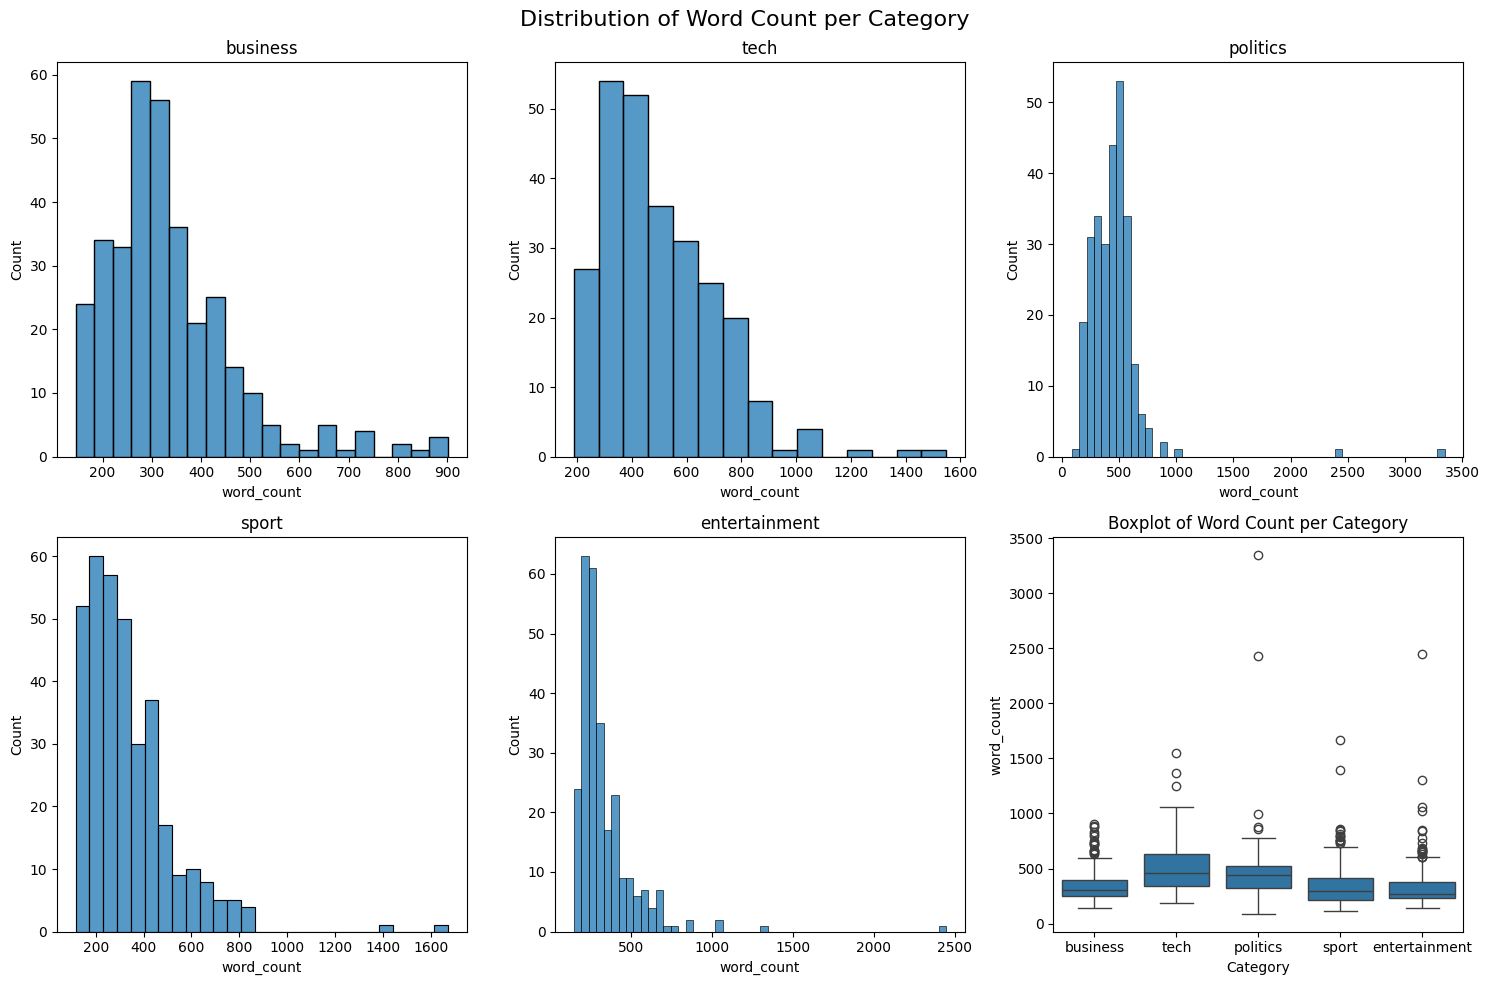

In [5]:
#building distribution charts of word count per category
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Word Count per Category', fontsize=16)

for i, category in enumerate(categories):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    sns.histplot(data=df_train[df_train['Category'] == category], x='word_count', ax=ax)
    ax.set_title(category)

# changing the last chart to be a poxblot
sns.boxplot(data=df_train, x='Category', y='word_count', ax=axs[1, 2])
axs[1, 2].set_title('Boxplot of Word Count per Category')

plt.tight_layout()
plt.show()


We have at least 260 articles for each category, meaning we won't have to exclude any category from our training dataset. By evaluating the distribution of word count, it is crucial to notice that articles sizes go from 90 to 3300+ words. If we want to want to be able to use words to train the model we'll need to normalize the word count per article.

We should also pay attention to the extra long articles (outliers), can they have a higher leverage and impact the performance of the supervised learning models? We'll do the analysis in the appropriate section.

### 1.2. Feature Cleaning (Text Processing)
We need to create new features based on the text for each article to use to train our models. The best way to do it is to calculate the frequency of each term in the document. Aiming to find the most relevant terms in each category we'll first check the occurrence of each word for the articles without any filtering, then we'll leverage sklearn's TF-IDF stopwords . TF_IDF is a statistical method used in information retrieval and natural language processing to evaluate how important a word is to a document within a collection of documents.

#### List of Most Common Words

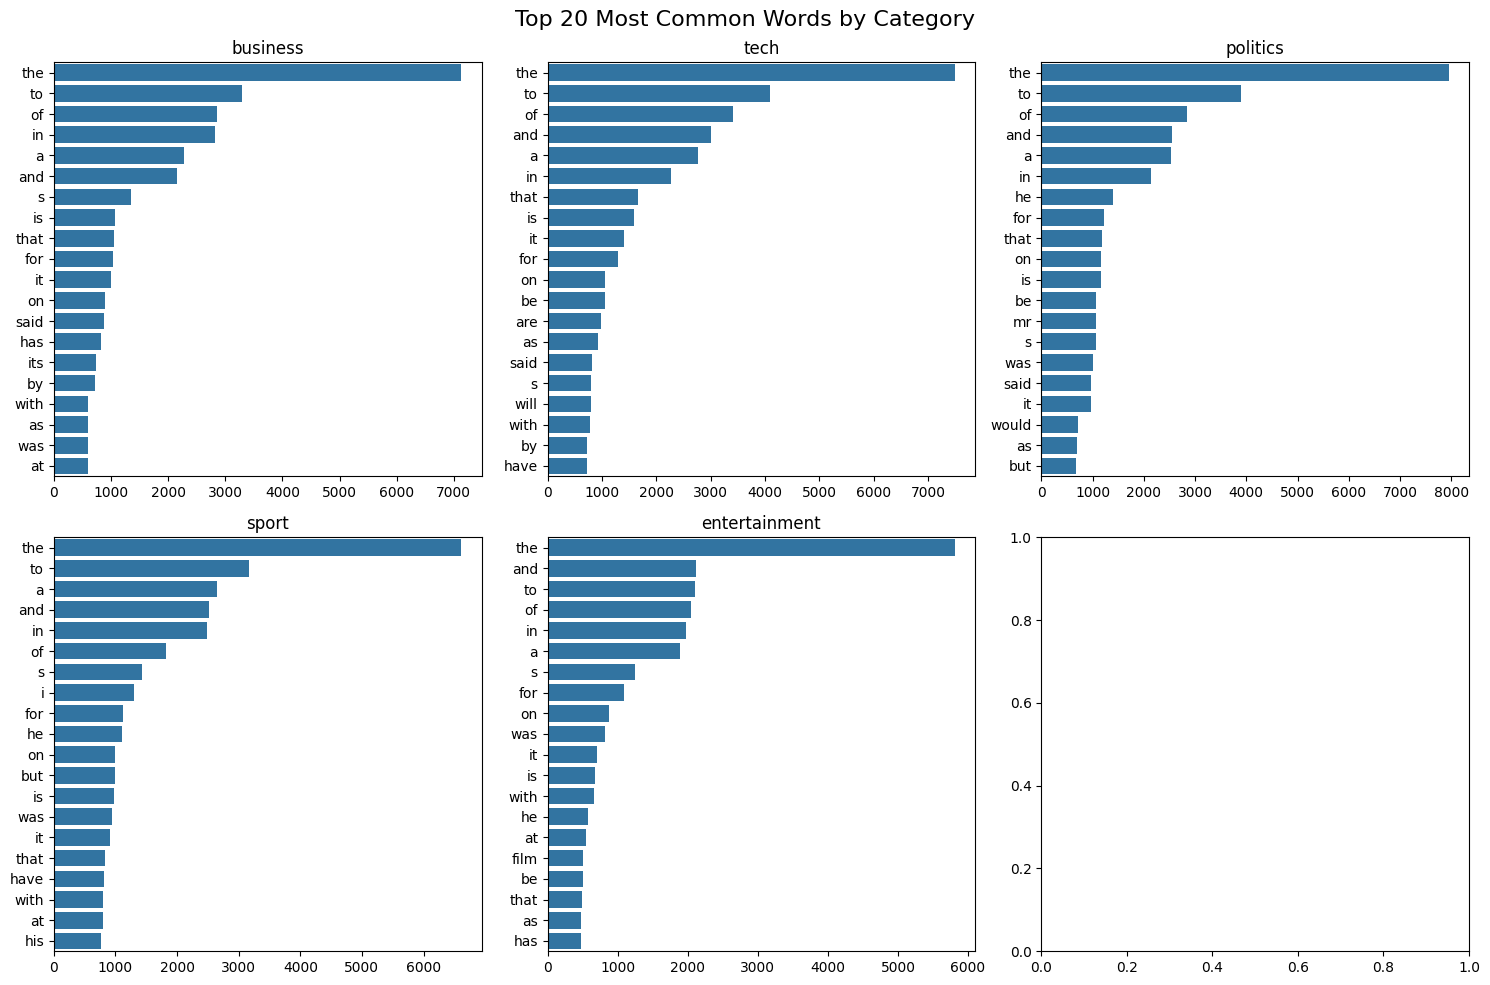

In [6]:
# checking the most common words in the articles by category
all_relevant_words ={}
for category in categories:
  all_relevant_words[category] = {}
  relevant_articles = df_train[df_train['Category'] == category]
  for article in relevant_articles['Text']:
    for word in article.split():
      all_relevant_words[category][word] = all_relevant_words[category].get(word, 0) + 1

#plotting the top 20 relevant words by category
list_len = 20 # how many word to show
relevant_words ={}
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Top 20 Most Common Words by Category', fontsize=16)
for i, category in enumerate(categories):
  row = i // 3
  col = i % 3
  ax = axs[row, col]
  relevant_words[category] = {k: v for k, v in sorted(all_relevant_words[category].items(), key=lambda item: item[1], reverse=True)}
  relevant_words[category] = {k: v for k, v in relevant_words[category].items() if v > 1}
  relevant_words[category] = dict(list(relevant_words[category].items())[:list_len])
  sns.barplot(x=list(relevant_words[category].values()), y=list(relevant_words[category].keys()), ax=ax)
  ax.set_title(category)

plt.tight_layout()
plt.show()

#### List of Most Common Filtered Words using TF-IDF
It is clear that the most common words for each category are stopwords and will be noise for the model so we should remove them before training models. We'll remove them manually using TF_IDF's stopwords.

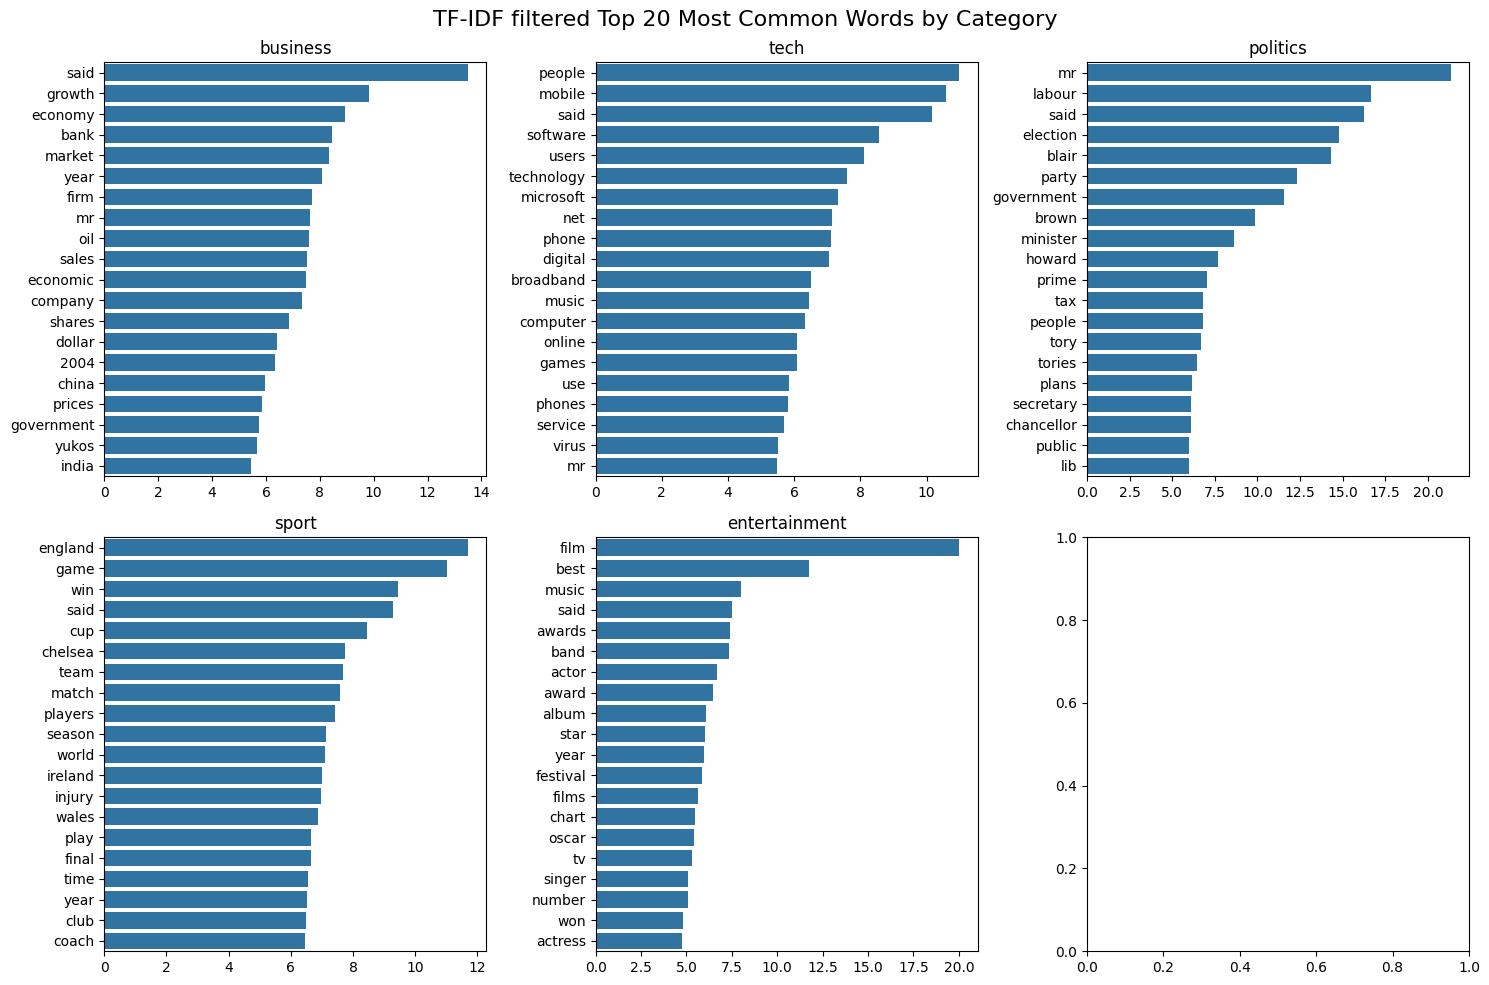

In [7]:
# from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizing the features
vectorizer = TfidfVectorizer(stop_words='english') #removing stopwords
tfidf_matrix = vectorizer.fit_transform(df_train['Text'])

#getting the columns and occurrences
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

#merging with orignal df to get the categories
full_train_df = pd.concat([df_train['Category'], tfidf_df], axis=1)

#plotting the 20 most relevant keywords by category
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('TF-IDF filtered Top 20 Most Common Words by Category', fontsize=16)
tfidf_relevant_words ={}
for i, category in enumerate(categories):
  row = i // 3
  col = i % 3
  ax = axs[row, col]
  #tfidf_relevant_words[category] = full_train_df[full_train_df['Category'] == category].sum().sort_values(ascending=False)
  tfidf_relevant_words[category] = full_train_df[full_train_df['Category'] == category].select_dtypes(include=['number']).sum().sort_values(ascending=False)
  tfidf_relevant_words[category] = dict(list(tfidf_relevant_words[category].items())[:list_len])
  sns.barplot(x=list(tfidf_relevant_words[category].values()), y=list(tfidf_relevant_words[category].keys()), ax=ax)
  ax.set_title(category)

plt.tight_layout()
plt.show()


## 2.Building and Comparing ML models
Now that we cleaned the data, we can go ahead and try different models and compare their performances. We'll do the following:


1.   Build Non-Negative Matrix Factorization (NMF) model
2.   Iterating the model: Reducing the number of max number of features
3.   Train a supervised learning model

#### 2.1 Building NMF model

In [48]:
#function to match categories to predicted numbers
# import itertools

def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
# your code here
    label_orderings = list(itertools.permutations(range(n)))
    # print (label_orderings)
    real_labels = categories.tolist()
    best_accuracy = 0
    best_ordering = None
    dict_mapping = None

    # y_true = ytdf.iloc[:,0].values # extract the label values for dict
    y_true = ytdf.values

    for ordering in label_orderings:
        # creates a dictionary
        mapping = {cluster_id: real_label for cluster_id, real_label in zip(ordering, real_labels)}

        # translates predictions based on te permutation
        y_pred = [mapping[cluster_id] for cluster_id in yp]

        accuracy = accuracy_score(y_true, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_ordering = ordering
            dict_mapping = mapping

    # print('Best ordering:', best_ordering)
    # print('Best accuracy:', best_accuracy)
    # print('Mapping:', dict_mapping)
    return best_ordering, best_accuracy, dict_mapping


#printing the confusion matrixes
def plot_cm_matrix(ytdf, yp, mapping):
  #replace values in yp to match the mapping
  # df['StandardLunch'] = df['LunchType'].map(lunch_type_dict)
  y_pred = y_pred = [mapping[cluster_id] for cluster_id in yp]
  cm = confusion_matrix(ytdf, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  # print('Accuracy:', accuracy)


Best ordering: (4, 2, 1, 0, 3)
Best accuracy: 0.9161073825503355
Mapping: {4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}


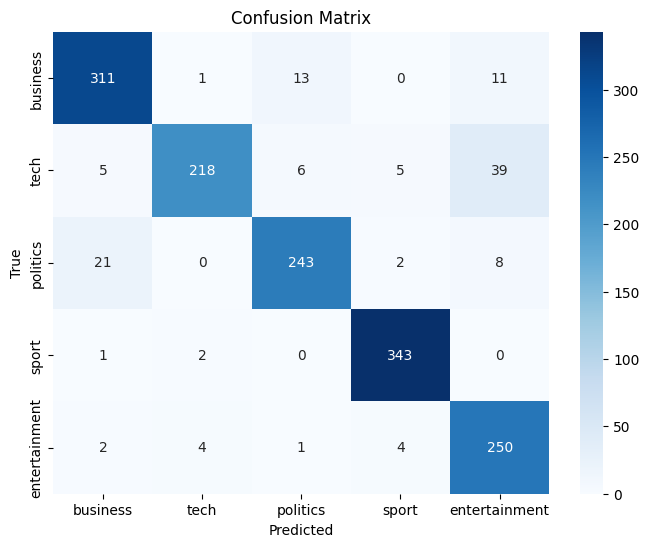

Best ordering: (0, 1, 2, 4, 3)
Best accuracy: 0.22312925170068026
Mapping: {0: 'business', 1: 'tech', 2: 'politics', 4: 'sport', 3: 'entertainment'}


In [27]:
# from sklearn.model_selection import train_test_split
# from sklearn.decomposition import NMF
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#splitting the data into train and test sets
#renaming the data into X & Y train to make it easier to refer back to
X_train = tfidf_matrix
y_train = df_train['Category']

X_test = vectorizer.transform(df_test['Text'])
y_test = df_test_y['Category']

# building the NMF
nmf = NMF(n_components=5)
W = nmf.fit_transform(X_train)
H = nmf.components_
yp = W.argmax(axis=1)

#checking nmf accuracy on training
ordering, accuracy, mapping = label_permute_compare(y_train,yp)
plot_cm_matrix(y_train,yp, mapping)

Best ordering: (0, 1, 2, 4, 3)
Best accuracy: 0.22312925170068026
Mapping: {0: 'business', 1: 'tech', 2: 'politics', 4: 'sport', 3: 'entertainment'}


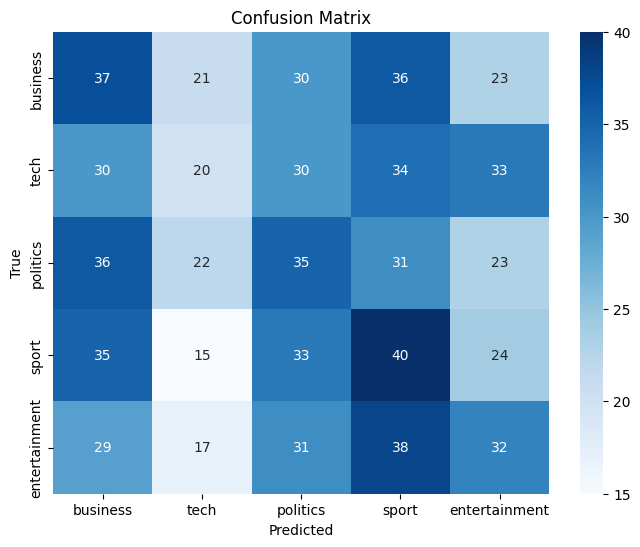

In [30]:
#tryin nmf on test data
yp = nmf.transform(X_test).argmax(axis=1)
ordering, accuracy, mapping = label_permute_compare(y_test,yp)

#creating the confusion matrix
plot_cm_matrix(y_test,yp, mapping)

Initially the accuracy results coming out of the training data (91.6%) seem very promissing, but when looking at the accuracy of the test set (22.3%) we can that there's a lot to improve in the model to ensure it is not overfitting. To do so, we'll try and reduce the number of features when using TF-IDF. We'll change the max_df parameter to filter terms based on their document frequency.

#### 2.2. Iterating the model: Reducing the number of max number of features

Max_df value: 0.4 Number of features: 24453
Train Accuracy: 0.9194630872483222 Test Accuracy: 0.2217687074829932
-----------------------------------------------------------------
Max_df value: 0.35 Number of features: 24450
Train Accuracy: 0.9268456375838926 Test Accuracy: 0.22312925170068026
-----------------------------------------------------------------
Max_df value: 0.3 Number of features: 24450
Train Accuracy: 0.9268456375838926 Test Accuracy: 0.22312925170068026
-----------------------------------------------------------------
Max_df value: 0.25 Number of features: 24443
Train Accuracy: 0.9268456375838926 Test Accuracy: 0.2217687074829932
-----------------------------------------------------------------
Max_df value: 0.2 Number of features: 24436
Train Accuracy: 0.9288590604026845 Test Accuracy: 0.2217687074829932
-----------------------------------------------------------------
Max_df value: 0.15 Number of features: 24403
Train Accuracy: 0.9268456375838926 Test Accuracy: 0.2231

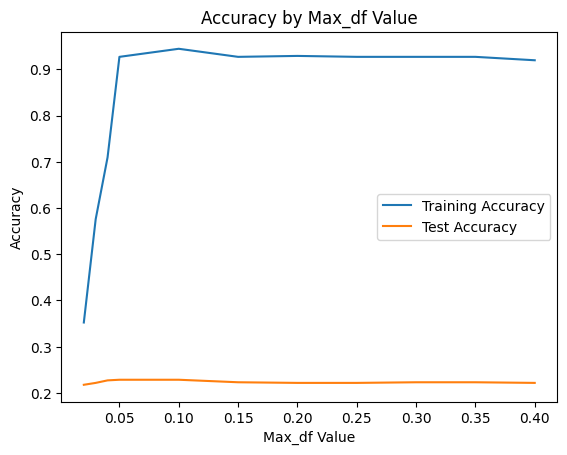

In [62]:
# creating the models with different max_df values
max_df_values =[i/100 for i in range(40,0,-5)]
max_df_values.append(0.04)
max_df_values.append(0.03)
max_df_values.append(0.02)

training_accuracies = []
test_accuracies = []

for max_df_value in max_df_values:
  vectorizer = TfidfVectorizer(stop_words='english', max_df=max_df_value)

  X_train = vectorizer.fit_transform(df_train['Text'])
  X_test = vectorizer.transform(df_test['Text'])

  number_of_features = vectorizer.get_feature_names_out().shape[0]

  nmf = NMF(n_components=5)
  W = nmf.fit_transform(X_train)

  yp_train = W.argmax(axis=1)
  ordering, train_accuracy, mapping = label_permute_compare(y_train,yp_train)

  yp_test = nmf.transform(X_test).argmax(axis=1)
  ordering, test_accuracy, mapping = label_permute_compare(y_test,yp_test)

  training_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

  if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    best_model = nmf

  print('Max_df value:', max_df_value, 'Number of features:', number_of_features)
  print('Train Accuracy:', train_accuracy, 'Test Accuracy:', test_accuracy)
  print('-----------------------------------------------------------------')
  # plot_cm_matrix(y_train,yp, mapping)

# accuracy chart by max df
fig, ax = plt.subplots()
ax.plot(max_df_values, training_accuracies, label='Training Accuracy')
ax.plot(max_df_values, test_accuracies, label='Test Accuracy')
ax.set_xlabel('Max_df Value')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Max_df Value')
ax.legend()
plt.show()

Interestingly when max_df = 0.1 is when our model score highest in the test and training data. But still have almost 24k features, only 500 less than the original model.

### 3.Building Supervised learning models
I've decided to test 2 approaches. Fisrt we'll use Random Forest, and then SVM (SVC specifically) for comparison to NMF. We'll leverage grid search to find the best parameters for our models.

We can't reuse the TF-IDF data to train our model right away so I'm recreating X_train & X_test.

#### 3.1. Random Forest

In [75]:
#building the random forest
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.1)
X_train = vectorizer.fit_transform(df_train['Text'])
X_test = vectorizer.transform(df_test['Text'])

rf_classifier = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 500], 'max_depth': [None, 1,2,3,4,5]}
grid_search = GridSearchCV(rf_classifier, param_grid, refit=True, verbose=3)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ...max_depth=None, n_estimators=50;, score=0.933 total time=   2.2s
[CV 2/5] END ...max_depth=None, n_estimators=50;, score=0.936 total time=   1.6s
[CV 3/5] END ...max_depth=None, n_estimators=50;, score=0.960 total time=   1.7s
[CV 4/5] END ...max_depth=None, n_estimators=50;, score=0.960 total time=   2.3s
[CV 5/5] END ...max_depth=None, n_estimators=50;, score=0.966 total time=   2.9s
[CV 1/5] END ..max_depth=None, n_estimators=100;, score=0.943 total time=   3.1s
[CV 2/5] END ..max_depth=None, n_estimators=100;, score=0.940 total time=   1.7s
[CV 3/5] END ..max_depth=None, n_estimators=100;, score=0.953 total time=   1.7s
[CV 4/5] END ..max_depth=None, n_estimators=100;, score=0.966 total time=   1.7s
[CV 5/5] END ..max_depth=None, n_estimators=100;, score=0.966 total time=   1.7s
[CV 1/5] END ..max_depth=None, n_estimators=150;, score=0.943 total time=   3.4s
[CV 2/5] END ..max_depth=None, n_estimators=150

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200, 250, 500]},
             verbose=3)

RandomForestClassifier(n_estimators=250)
Train Accuracy:  1.0


<Axes: >

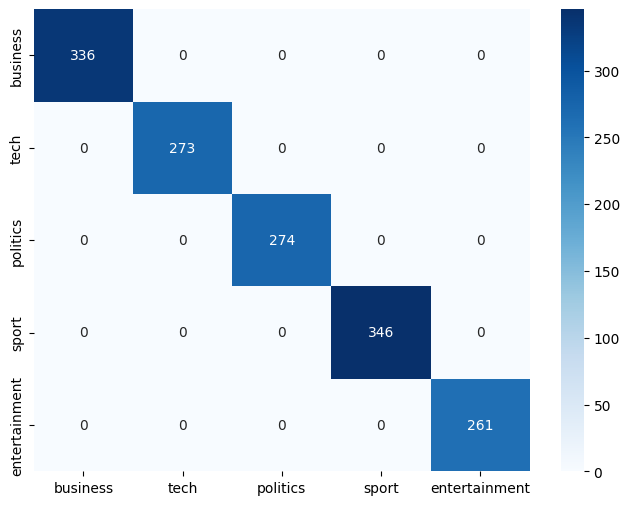

In [76]:
print(grid_search.best_estimator_)

print('Train Accuracy: ',grid_search.score(X_train, y_train))
#confusion matrix
y_pred = grid_search.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)

Test Accuracy:  0.1836734693877551


<Axes: >

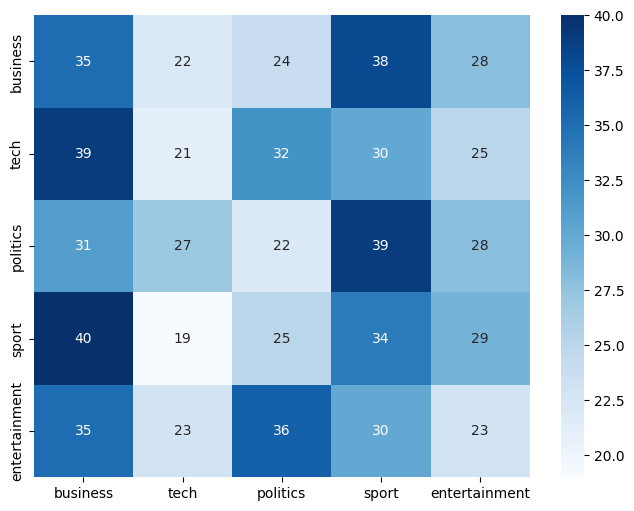

In [77]:
#Test prediction
print('Test Accuracy: ',grid_search.score(X_test, y_test))
#confusion matrix
y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)

#### 3.2. Support Vector Classifier (SVC)

In [64]:
#building the SVC
# from sklearn.svm import SVC

# vectorizer = TfidfVectorizer(stop_words='english', max_df=0.1)
# X_train = vectorizer.fit_transform(df_train['Text'])
# X_test = vectorizer.transform(df_test['Text'])

sv_classifier = SVC()
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}
grid_search = GridSearchCV(sv_classifier, param_grid, refit=True, verbose=3)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.232 total time=   4.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.235 total time=   3.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.232 total time=   3.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.232 total time=   3.8s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.232 total time=   3.6s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.232 total time=   3.7s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.235 total time=   4.2s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.232 total time=   3.6s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.232 total time=   3.6s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.232 total time=   4.2s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.664 total time=   3.5s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=3)

SVC(C=1, gamma=1, kernel='sigmoid')
Train Accuracy:  0.9986577181208054


<Axes: >

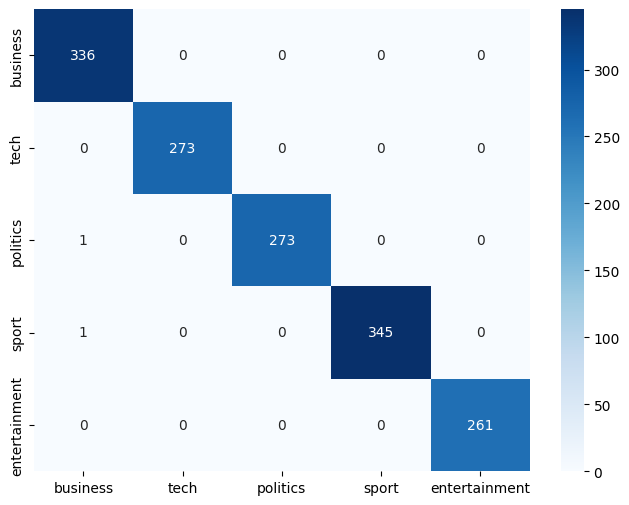

In [74]:
#SVC(C=1, gamma=1, kernel='sigmoid')
# print(grid_search.best_params_)
print(grid_search.best_estimator_)

print('Train Accuracy: ',grid_search.score(X_train, y_train))
#confusion matrix
y_pred = grid_search.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)



Accuracy:  0.19047619047619047


<Axes: >

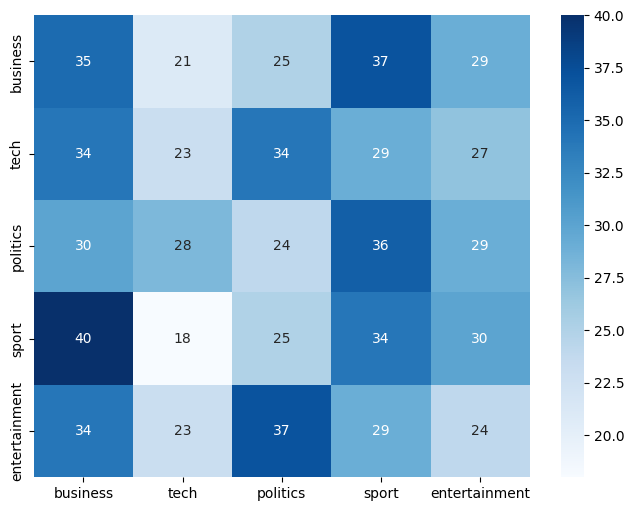

In [73]:
#Test prediction
print('Test Accuracy: ',grid_search.score(X_test, y_test))
#confusion matrix
y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)

In [68]:
sv_classifier = SVC()
sv_classifier.fit(X_train, y_train)

SVC()

### 4.Discussion & Conclusion

1.  While all the models showed great perfomance on the training dataset, all of them scored poorly in the test dataset. This is an indicator that the models are overfitting and therefore performing poorly in a new data environment. This is very likely due to the noise in the data, indicating that further text processing and cleaning should be done before using this data to train models.

2.  TF-IDF has shown to be a great tool to help prepping and cleaning text data to be used in Machine Learning Models. Surprisingly changing the max_df (max number of features in the dataset) had no impact at higher percentages (> 40%) and with a max_df of 10% there were still 24k features in the model.

3. NMF is specially powerfull when thinking that you don't labels to train the data and can achieve performance comparable or even superior than supervised learning models. NMF scored highest (~ 23% in the test data, vs 18% RF and 19% SVC)

**Recommended Next Steps**: I belive the performance of all models can improve with further data cleaning to help reduce the noise in the training dataset. A few suggestions coming from further research on the topic: removing numbers, lowercasing words, removing special characters.



### References:


1.   https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
2.   https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
3.  https://github.com/RyanJTalbot/MSDS/blob/main/Core/Machine%20Learning%3A%20Theory%20and%20Hands-on%20Practice%20with%20Python%20Specialization%20/Unsupervised%20Algorithms%20in%20Machine%20Learning/wk4/review%20of%20peers/BBC%20news%20classification.ipynb
4. https://www.kaggle.com/code/robinlutter/bbc-news-classification-nmf-vs-supervised#4.2-Initial-Model-Building

